In [2]:
#import tensorflow as tf
import librosa
import os
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load style and content

In [3]:
CONTENT_FILENAME = "inputs/gettysburg.mp3"
STYLE_FILENAME = "inputs/gettysburg.mp3"#"inputs/fire.mp3"
TorFasChannels = "F"
N_FILTERS = 4096
hor_filter = 41
OUTPUT_FILENAME = 'outputs/getty_new.wav'

In [4]:
display(Audio(CONTENT_FILENAME))
display(Audio(STYLE_FILENAME))

In [5]:
N_FFT = 2048
K_HOP = 1024
def read_audio_spectum1(filename):
    x, fs = librosa.load(filename) #x=audiodata, fs=samplerate
    S = np.abs(librosa.stft(x, n_fft=N_FFT, hop_length=K_HOP, win_length=N_FFT,  center=True))
    print(S.shape)
    S = np.log1p(S[:,:430])
    #D = librosa.amplitude_to_db(S, ref=np.max)
    return S, fs

In [5]:
# Reads wav file and produces spectrum
# Fourier phases are ignored

def read_audio_spectum2(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x, N_FFT)
    print(S.shape)
    p = np.angle(S)
    
    S = np.log1p(np.abs(S[:,:430]))  
    return S, fs

In [6]:
a_content, fs = read_audio_spectum1(CONTENT_FILENAME)
print(a_content.shape,fs)
a_style, fs = read_audio_spectum1(STYLE_FILENAME)
print(a_style.shape,fs)
print(np.amin(a_style),np.amax(a_style))

N_SAMPLES = a_content.shape[1] #time bins
N_CHANNELS = a_content.shape[0] #freq bins
a_style = a_style[:N_CHANNELS, :N_SAMPLES]


(1025, 216)
(1025, 216) 22050
(1025, 216)
(1025, 216) 22050
9.6456e-08 4.54282


### Visualize spectrograms for content and style tracks

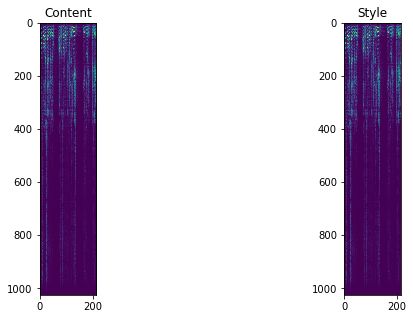

In [7]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Content')
plt.imshow(a_content[:,:]) #[:400,:]
plt.subplot(1, 2, 2)
plt.title('Style')
plt.imshow(a_style[:,:]) #[:400,:]
plt.show()

In [8]:
a_content_ori = np.ascontiguousarray(a_content[None,None,:,:])
a_style_ori = np.ascontiguousarray(a_style[None,None,:,:])
a_content_tf = np.ascontiguousarray(a_content.T[None,None,:,:])
a_style_tf = np.ascontiguousarray(a_style.T[None,None,:,:])
print(a_content_ori.shape,a_style_ori.shape) #[batch,height,width,channels]
print(a_content_tf.shape,a_style_tf.shape) #[batch,height,width,channels]

(1, 1, 214, 1025) (1, 1, 214, 1025)
(1, 1, 1025, 214) (1, 1, 1025, 214)


### Compute content and style feats

In [9]:
#Feed content and style spectrograms into a CNN with random weights
#extract features from both spectrograms

a_content_ori = np.ascontiguousarray(a_content[None,None,:,:])
a_style_ori = np.ascontiguousarray(a_style[None,None,:,:])
a_content_tf = np.ascontiguousarray(a_content.T[None,None,:,:])
a_style_tf = np.ascontiguousarray(a_style.T[None,None,:,:])
#print(a_content_tf.shape,a_style_tf.shape) #[batch,height,width,channels]

# filter shape is "[filter_height, filter_width, in_channels, out_channels]"
std = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS) * hor_filter)) #N_CHANNELS=input depth ie. freq bins,N_FILTERS=output depth

if TorFasChannels == "F":
    kernel = np.random.randn(1, hor_filter, N_CHANNELS, N_FILTERS)*std # kernel shape is 1X11 in 1D
else:
    kernel = np.random.randn(1, hor_filter, N_SAMPLES, N_FILTERS)*std # kernel shape is 1X11 in 1D
    
with tf.Session() as sess:
    # data shape is "[batch, in_height, in_width, in_channels]",
    if TorFasChannels == "F":
        x = tf.placeholder('float32', [1,1,N_SAMPLES,N_CHANNELS], name="x") #input = [batch,height,width,channels]
    else:
        x = tf.placeholder('float32', [1,1,N_CHANNELS,N_SAMPLES], name="x") #input = [batch,height,width,channels]

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")
    
    net = tf.nn.relu(conv)

    if TorFasChannels == "F":
        content_features = net.eval(feed_dict={x: a_content_tf})
        style_features = net.eval(feed_dict={x: a_style_tf})
    else:
        content_features = net.eval(feed_dict={x: a_content_ori})
        style_features = net.eval(feed_dict={x: a_style_ori})
    print(style_features.shape)
    features = np.reshape(style_features, (-1, N_FILTERS))
    #print(features[:,1].shape)

    style_gram = np.matmul(features.T, features) / N_SAMPLES #preserve freq
    #style_gram = np.matmul(features, features.T) / N_FILTERS #preserve time
    print(style_gram.shape)
    #print(style_gram)

(1, 1, 174, 4096)
(4096, 4096)


q = np.correlate(features[:,2],features[:,2],mode='same')

corr_style = np.zeros([420,4096])
i = 0
while i < 4096:
    corr_style[:,i] = np.correlate(features[:,i],features[:,i],mode='same')
    i += 1
print(corr_style.shape)
#print(corr_style)

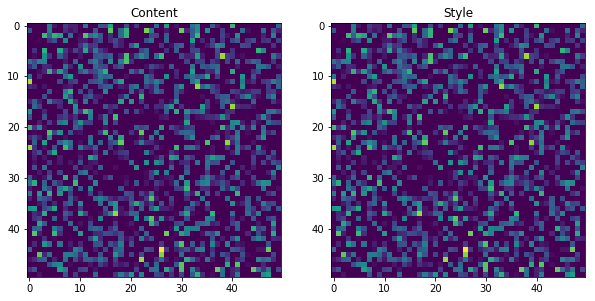

In [10]:
#print(content_features.shape)
#print(features.shape)
#print(style_features.shape)
content_feat = np.reshape(content_features, (N_FILTERS,-1))
style_feat = np.reshape(style_features, (N_FILTERS,-1))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Content')
plt.imshow(content_feat[2500:2550,0:50])
plt.subplot(1, 2, 2)
plt.title('Style')
plt.imshow(style_feat[2500:2550,0:50])
plt.show()


### Optimize

In [11]:
from sys import stderr

ALPHA= 8e-3
learning_rate= 1e-3 #not used
iterations = 100 #not used

result = None
with tf.Graph().as_default():

    # Build graph with variable input
    #x = tf.Variable(np.zeros([1,1,N_SAMPLES,N_CHANNELS], dtype=np.float32), name="x")
    if TorFasChannels == "F":
        x = tf.Variable(np.random.randn(1,1,N_SAMPLES,N_CHANNELS).astype(np.float32)*1e-3, name="x") #start with a random image
    else:
        x = tf.Variable(np.random.randn(1,1,N_CHANNELS,N_SAMPLES).astype(np.float32)*1e-3, name="x") #start with a random image

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")
    
    
    net = tf.nn.relu(conv)

    content_loss = ALPHA * 2 * tf.nn.l2_loss(
            net - content_features)  # compare content features of random image to the previous 'content' image

    style_loss = 0

    _, height, width, number = map(lambda i: i.value, net.get_shape())

    size = height * width * number
    feats = tf.reshape(net, (-1, number))
    
    gram = tf.matmul(tf.transpose(feats), feats)  / N_SAMPLES
    #gram = tf.matmul(feats, tf.transpose(feats))  / N_FILTERS
    
    #style_loss = 2 * tf.nn.l2_loss(corr - corr_style)
    style_loss = 2 * tf.nn.l2_loss(gram - style_gram) #compare style features of random image to previous 'style' image

     # Overall loss
    #loss = content_loss + style_loss #combine both content and style loss
    loss = style_loss

    opt = tf.contrib.opt.ScipyOptimizerInterface(
          loss, method='L-BFGS-B', options={'maxiter': 500}) #optimize to reduce the loss, get it close to a combination of content and stlye images
        
    # Optimization
    with tf.Session() as sess:
        tf.global_variables_initializer().run()        
       
        print('Started optimization.')
        opt.minimize(sess)
    
        print ('Final loss:', loss.eval())
        result = x.eval() #return input layer

Started optimization.
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 25.957047
  Number of iterations: 501
  Number of functions evaluations: 526
Final loss: 25.957


In [12]:
print(result.shape)
print(result[0,0].shape)

(1, 1, 214, 1025)
(214, 1025)


### Invert spectrogram and save the result

In [19]:
a = np.zeros_like(a_content)
print(a.shape)
if TorFasChannels == "F":
    a[:N_CHANNELS,:] = np.exp(result[0,0].T) - 1 #inverse of np.log1p
else:
    a[:N_CHANNELS,:] = np.exp(result[0,0]) - 1

# This code is supposed to do phase reconstruction, this is the Griffin & Lim algo
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi #start with some phase
for i in range(500):
    S = a * np.exp(1j*p) #use magnitude a given by spectrogram and some random phase
    x = librosa.istft(S,hop_length=K_HOP, win_length=N_FFT,  center=True) #do the inverse transform
    p = np.angle(librosa.stft(x, n_fft=N_FFT, hop_length=K_HOP, win_length=N_FFT,  center=True)) #use this new phase value
librosa.output.write_wav(OUTPUT_FILENAME, x, fs)

(1025, 214)


### Visualize spectrograms

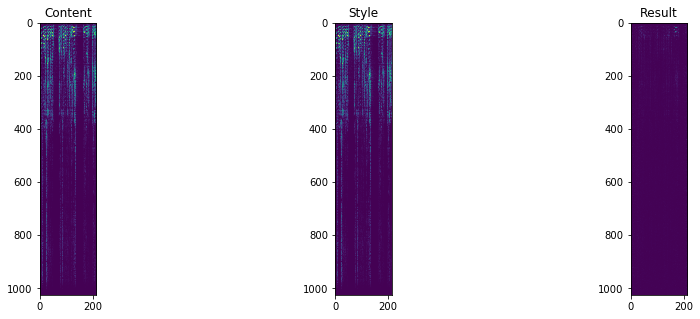

In [20]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Content')
plt.imshow(a_content[:,:])
plt.subplot(1,3,2)
plt.title('Style')
plt.imshow(a_style[:,:])
plt.subplot(1,3,3)
plt.title('Result')
plt.imshow(a[:,:])
plt.show()

In [21]:
print(OUTPUT_FILENAME)
display(Audio(OUTPUT_FILENAME))

outputs/getty_new.wav
